# Decipher modifications 






## Structure of the variational family


Variational family factorizes into 
$\begin{eqnarray*}
q_{\mathtt{joint}} := q(v_s, v_x, z_x, z_y, z_s) & = & \prod_{i=1}^N q(v_{s,i}, v_{x,i}, z_{x,i}, z_{y,i}, z_{s,i}) \\
q(v_{s,i}, v_{x,i}, z_{x,i}, z_{y,i}, z_{s,i}) & = & q(v_{x,i}|z_{x,i},z_{s,i}) \times q(z_{x,i},z_{s,i}|x_i) \times q(v_{s,i}|z_{s,i},  z_{y,i}) \times q(z_{s,i}|y_i) \times q(z_{y,i}|y_i)
\end{eqnarray*}$ 


Set
- $q(v_{x,i}|z_{x,i},z_{s,i}) = \mathcal{N}(d^{\rightarrow v_x}_{\mathtt{mean}}(z_{x,i}, z_{s,i}), d^{\rightarrow v_x}_{\mathtt{var}}(z_{x,i}, z_{s,i}))$
- $q(v_{s,i}|z_{y,i},z_{s,i}) = \mathcal{N}(d^{\rightarrow v_s}_{\mathtt{mean}}(z_{y,i}, z_{s,i}), d^{\rightarrow v_s}_{\mathtt{var}}(z_{y,i}, z_{s,i}))$
- $q(z_{x,i},z_{s,i}|x_i) = \mathcal{N}(d^{\rightarrow z_{s,x}}_{\mathtt{mean}}(x_i), d^{\rightarrow z_{s,x}}_{\mathtt{var}}(x_i))$
- $q(z_{s,i}|y_i) = \mathcal{N}(d^{\rightarrow z_{s,y}}_{\mathtt{mean}}(y_i), d^{\rightarrow z_{s,y}}_{\mathtt{var}}(y_i))$
- $q(z_{y,i}|y_i) = \mathcal{N}(d^{\rightarrow z_{y}}_{\mathtt{mean}}(y_i), d^{\rightarrow z_{y}}_{\mathtt{var}}(y_i))$

Variational inference objective:

$\begin{eqnarray} 
& \mathcal{L}_{\text{ELBO}}(q)  = \sum_{i=1}^{N} \mathbb{E}_{q_{\mathtt{joint}} }\bigg( \sum_g \log p(x_{i,g}|z_{s,i}, z_{x,i}, \theta_g) + \log \frac{p(z_{s,i}, z_{x,i}|v_{x,i}, v_{s,i})}{q(z_{x,i}, z_{s,i}|x_{i,g})} + \beta_x \log \frac{p(v_{x,i})}{q(v_{x,i}|z_{x,i},z_{s,i})}  \\
& + \sum_t  \log p(y_{i,t}|z_{s,i}, z_{y,i}, \eta_t) + \log \frac{p(z_{s,i}, z_{y,i}|v_{s,i})}{q(z_{y,i}, z_{s,i}|y_{i,t})} + \beta_s \log \frac{p(v_{s,i})}{q(v_{s,i}|z_{y,i},z_{s,i})} \bigg)
\end{eqnarray}$

$v \in \mathbb{R}^2, z \in \mathbb{R}^{10}, x, y \in \mathbb{R}^{2000}$

### Decipher module adapted for ATAC

In [10]:
import dataclasses
from dataclasses import dataclass
from typing import Sequence, Union

import numpy as np
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import torch
import torch.nn as nn
import torch.utils.data
from torch.distributions import constraints
from torch.nn.functional import softmax, softplus


In [15]:
# pip install randomname

In [11]:
#help(pyro.param)

In [22]:
import decipher

# Testing on PDAC data

In [26]:
import scipy as sp
from decipher.tools._decipher import Decipher_with_ATAC, DecipherConfig_withATAC
from decipher.tools.decipher import decipherATAC_train

In [31]:
pdac_atac = sc.read_h5ad("/Users/clairehe/Documents/GitHub/decipher_with_ATAC/data/pdac_atac.h5ad")
pdac_atac.X = sp.sparse.csr_matrix(pdac_atac.X)

In [32]:
pdac_rna = sc.read_h5ad("/Users/clairehe/Documents/GitHub/decipher_with_ATAC/data/pdac_rna.h5ad")
pdac_rna.X = sp.sparse.csr_matrix(pdac_rna.X)

In [33]:
pdac_rna

AnnData object with n_obs × n_vars = 3988 × 21821
    obs: 'orig.ident', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'nonprimary', 'passed_filters', 'is__cell_barcode', 'excluded_reason', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nCount_ATAC', 'nFeature_ATAC', 'dataset', 'nCount_RNA', 'nFeature_RNA', 'nucleosome_signal', 'nucleosome_percentile', 'nucleosome_group', 'TSS.enrichment', 'TSS.percentile', 'high.tss', 'pct_reads_in_peaks', 'blacklist_ratio', 'ATAC_snn_res.1.2', 'seurat_clusters', 'predicted.id', 'prediction.score.B.cell', 'prediction.score.Endothelial', 'prediction.score.Ductal', 'prediction.score.T.cell', 'prediction.score.Epi.Immune', 'prediction.score.Proliferating', 'prediction.score.Tumor.1', 'prediction.score.Macrophage', 'prediction.score.Acinar', 'prediction.score.Fibr

In [34]:
pdac_atac

AnnData object with n_obs × n_vars = 3988 × 258561
    obs: 'orig.ident', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'nonprimary', 'passed_filters', 'is__cell_barcode', 'excluded_reason', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nCount_ATAC', 'nFeature_ATAC', 'dataset', 'nCount_RNA', 'nFeature_RNA', 'nucleosome_signal', 'nucleosome_percentile', 'nucleosome_group', 'TSS.enrichment', 'TSS.percentile', 'high.tss', 'pct_reads_in_peaks', 'blacklist_ratio', 'ATAC_snn_res.1.2', 'seurat_clusters', 'predicted.id', 'prediction.score.B.cell', 'prediction.score.Endothelial', 'prediction.score.Ductal', 'prediction.score.T.cell', 'prediction.score.Epi.Immune', 'prediction.score.Proliferating', 'prediction.score.Tumor.1', 'prediction.score.Macrophage', 'prediction.score.Acinar', 'prediction.score.Fib

2023-12-01 15:05:15,130 | INFO : Added `.obs['decipher_split']`: the Decipher train/validation split.
 398 cells in validation set.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
2023-12-01 15:05:15,143 | INFO : Added `.obs['decipher_split']`: the Decipher train/validation split.
 398 cells in validation set.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


V5


Epoch 0 | train elbo: 67546.78 | val ll: 18279.29:   0%|          | 0/100 [02:38<?, ?it/s]2023-12-01 15:09:24,576 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:09:24,579 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/sca

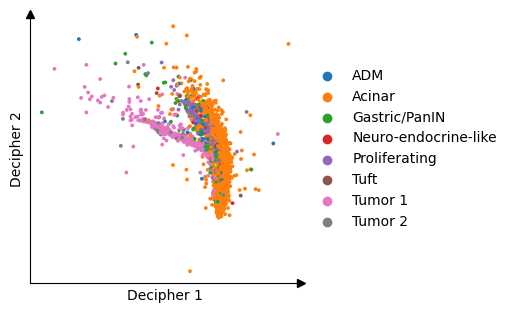

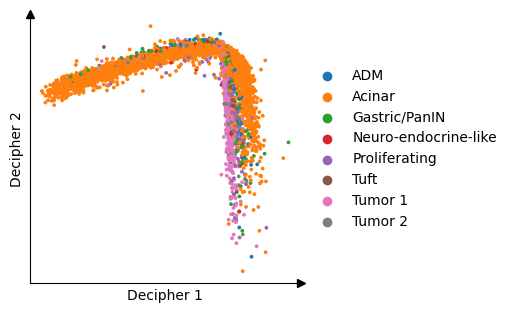

Epoch 1 | train elbo: 61889.16 | val ll: 17929.73:   1%|          | 1/100 [07:14<6:50:48, 248.97s/it]2023-12-01 15:12:48,612 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2023-12-01 15:12:48,616 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/clairehe/anaconda3/envs/cpa/lib/python3.9/site-p

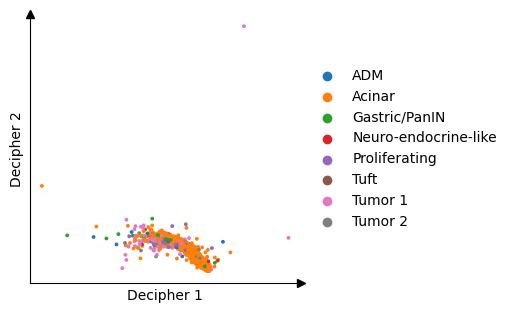

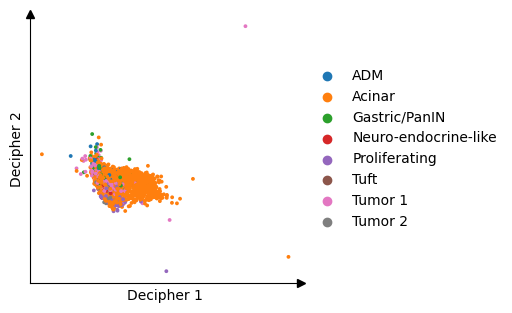

Epoch 1 | train elbo: 61889.16 | val ll: 17929.73:   2%|▏         | 2/100 [07:32<6:03:23, 222.48s/it]

In [ ]:
config = DecipherConfig_withATAC(
    dim_genes = pdac_rna.shape[1],
    dim_atac= pdac_atac.shape[1])
decipherATAC_train(
    pdac_rna,
    pdac_atac,
    decipher_config=DecipherConfig_withATAC(),
    plot_every_k_epoch=1,
    plot_kwargs=dict(
        color=[
         "predicted.id"
        ])
)


## Decipher plot (no modif)


Add variance contour plot. 

In [ ]:
import numpy as np
import scanpy as sc
from matplotlib import pyplot as plt


def decipher_z(
    adata,
    basis="decipher_v",
    decipher_z_key="decipher_z",
    subset_of_zs=None,
    **kwargs,
):
    """Plot the Decipher v space colored by each dimension of the Decipher z space.

    Parameters
    ----------
    adata : sc.AnnData
        The annotated data matrix.
    basis : str, default "decipher_v"
        The basis to use for the plot.
    decipher_z_key : str, default "decipher_z"
        The key in `adata.obsm` where the decipher z space is stored.
    subset_of_zs : list of int, optional
        The dimensions of the decipher z space to plot. If None, plot all dimensions.
    **kwargs : dict, optional
        Additional arguments passed to `sc.pl.embedding`.

    Returns
    -------
    fig : matplotlib.pyplot.Figure
        The matplotlib figure.
    """
    dim_z = adata.obsm[decipher_z_key].shape[1]
    for i in range(dim_z):
        adata.obs["z%d" % (i + 1)] = adata.obsm[decipher_z_key][:, i]

    if subset_of_zs is None:
        subset_of_zs = list(range(1, dim_z + 1))

    return sc.pl.embedding(
        adata,
        basis=basis,
        color=[f"z{i}" for i in subset_of_zs],
        vmax=lambda xs: np.quantile(xs, 0.99),
        vmin=lambda xs: np.quantile(xs, 0.01),
        color_map="cool_r",
        frameon=False,
        show=False,
        sort_order=False,
        return_fig=True,
        **kwargs,
    )


def decipher(
    adata,
    color=None,
    palette=None,
    ncols=2,
    subsample_frac=1.0,
    title="",
    basis="decipher_v",
    x_label="Decipher 1",
    y_label="Decipher 2",
    axis_type="arrow",
    figsize=(3.5, 3.5),
    vmax=lambda xs: np.quantile(xs[~np.isnan(xs)], 0.99),
    **kwargs,
):
    """Plot the Decipher v space.

    Parameters
    ----------
    adata : sc.AnnData
        The annotated data matrix.
    color : str or list of str
        Keys for annotations of cells, given to `sc.pl.embedding`.
    palette : dict, optional
        A dictionary mapping color keys to colors.
    ncols : int, default 2
        Number of columns in the plot.
    subsample_frac : float, default 1.0
        Fraction of cells to plot. Useful for large datasets.
    title : str, default ""
        Title of the plot. Only used if `color` is a single key, otherwise the title for each
        subplot is set automatically to the name of the color key.
    basis : str, default "decipher_v"
        The basis to use for the plot.
    x_label : str, default "Decipher 1"
        The label for the x-axis.
    y_label : str, default "Decipher 2"
        The label for the y-axis.
    axis_type : str, default "arrow"
        The type of axis to use. Can be "arrow", "line", or "none".
        If "arrow", the axes are drawn as arrows, with no top or right spines.
        If "line", the axes are drawn as lines, with all spines.
        If "none", no axes are drawn.
    figsize : tuple, default (3.5, 3.5)
        The size of the figure.
    vmax : function, optional
        A function that takes a numpy array and returns a float. Used to set the maximum value of
        the colorbar. By default, the 99th percentile of the data is used.
    **kwargs : dict, optional
        Additional arguments passed to `sc.pl.embedding`.

    Returns
    -------
    fig : matplotlib.pyplot.Figure
        The matplotlib figure.

    See Also
    --------
    sc.pl.embedding

    """
    with plt.rc_context({"figure.figsize": figsize}):
        fig = sc.pl.embedding(
            sc.pp.subsample(adata, subsample_frac, copy=True),
            basis=basis,
            color=color,
            palette=palette,
            return_fig=True,
            frameon=(axis_type in ["line", "arrow"]),
            ncols=ncols,
            vmax=vmax if color is not None else None,
            **kwargs,
        )
    ax = fig.axes[0]
    if color is None or type(color) == str:
        color = [color]

    if len(color) == 1:
        ax.set_title(title)

    for i, ax in enumerate(fig.axes):
        if ax._label == "<colorbar>":
            continue
        if axis_type == "arrow":
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.plot(1, 0, ">k", transform=ax.transAxes, clip_on=False)
            ax.plot(0, 1, "^k", transform=ax.transAxes, clip_on=False)

        if axis_type != "none":
            if i % ncols == 0:
                ax.set_ylabel(y_label)
            else:
                ax.set_ylabel(None)
            if i // ncols == (len(color) - 1) // ncols:
                ax.set_xlabel(x_label)
            else:
                ax.set_xlabel(None)
    return fig
